# Discovery notebook

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from pathlib import Path
from IPython.display import display, HTML
from tabulate import tabulate
from scipy.stats import pearsonr

plt.rcParams["figure.dpi"] = 100

Let's define some useful functions. 

In [2]:
# Taken from https://www.kaggle.com/andradaolteanu/siim-covid-19-box-detect-dcm-metadata
def show_values_on_bars(axs, h_v="v", space=0.4):
    '''Plots the value at the end of the a seaborn barplot.
    axs: the ax of the plot
    h_v: weather or not the barplot is vertical/ horizontal'''
    
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(round(_x, 5), round(_y, 5), format(round(value, 5), ','), ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, format(value, ','), ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [3]:
cab = pd.read_csv("Cab_Data.csv")
cab.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [4]:
cab.Company.unique()

array(['Pink Cab', 'Yellow Cab'], dtype=object)

As expected, two different companies. What are their proportions? 

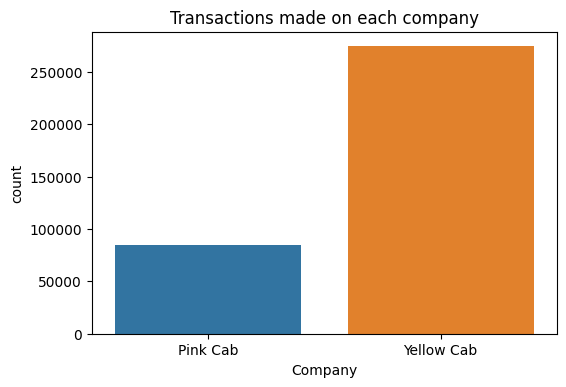

In [5]:
sns.countplot(x=cab.Company)
_ = plt.title("Transactions made on each company")

There are more transactions made with `Yellow Cab` company than `Pink Cab`. 

Let's look at `Date of Travel`. Does popularity of Cab increase as time pass? Since the date is being reformatted, we don't know whether they're arranged in increment order or not. **We'll assume they are in increment order, meaning that larger value of date is latter than smaller value**. If this assumption is false, the information below cannot be used. 

Also, we are given on the assignment that the date range from 31/01/2016 to 31/12/2018. So this is 3 years long, we can see that it is a 3 years seasonality. We use `bins=36` so each bin equals one month. 

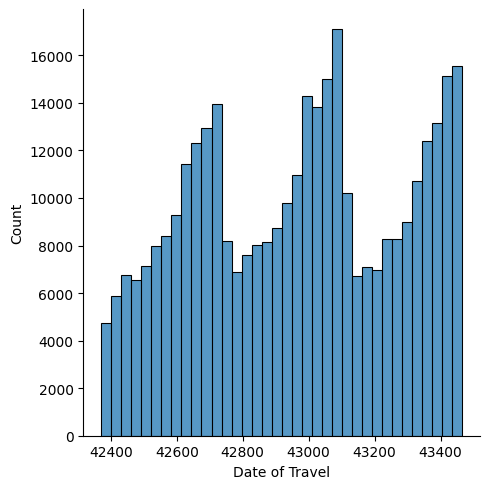

In [6]:
sns.displot(x="Date of Travel", data=cab, bins=36)

Looks like **seasonality** is present, where cab became popular at a certain time period and not so popular at other time period.

We also want to know whether one Cab is more popular over the other as time pass. 

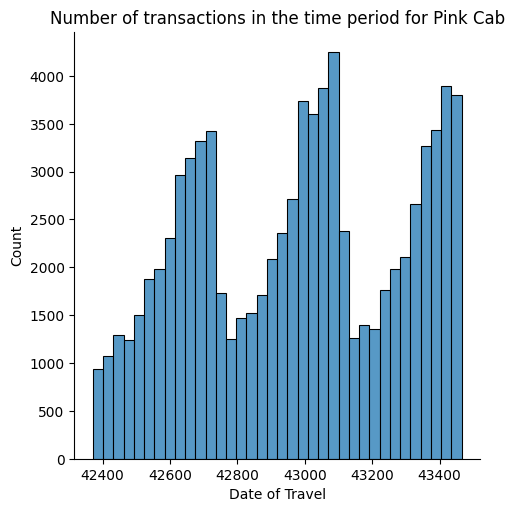

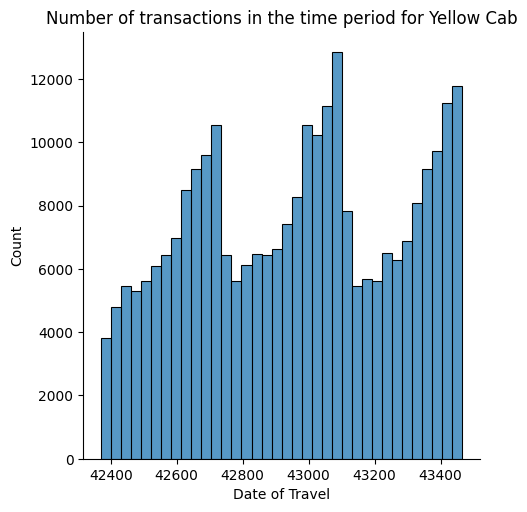

In [7]:
for title, data in cab.groupby("Company")["Date of Travel"]:
    sns.displot(data, bins=36)
    plt.title(f"Number of transactions in the time period for {title}")

Looks like the seasonality is independent of which company it is, as we can see from the graphs above. Popularity (without comparing itself to another company, only to its history) doesn't change much over time. 

If it decreases, perhaps it's not even worth investing for after all. 

In [8]:
cab.City.unique()

array(['ATLANTA GA', 'AUSTIN TX', 'BOSTON MA', 'CHICAGO IL', 'DALLAS TX',
       'DENVER CO', 'LOS ANGELES CA', 'MIAMI FL', 'NASHVILLE TN',
       'NEW YORK NY', 'ORANGE COUNTY', 'PHOENIX AZ', 'PITTSBURGH PA',
       'SACRAMENTO CA', 'SAN DIEGO CA', 'SEATTLE WA', 'SILICON VALLEY',
       'TUCSON AZ', 'WASHINGTON DC'], dtype=object)

In [9]:
cab.nunique()

Transaction ID    359392
Date of Travel      1095
Company                2
City                  19
KM Travelled         874
Price Charged      99176
Cost of Trip       16291
dtype: int64

In [10]:
len(cab)

359392

In [11]:
cab.groupby("City")["Transaction ID"].count()

City
ATLANTA GA         7557
AUSTIN TX          4896
BOSTON MA         29692
CHICAGO IL        56625
DALLAS TX          7017
DENVER CO          3825
LOS ANGELES CA    48033
MIAMI FL           6454
NASHVILLE TN       3010
NEW YORK NY       99885
ORANGE COUNTY      3982
PHOENIX AZ         2064
PITTSBURGH PA      1313
SACRAMENTO CA      2367
SAN DIEGO CA      20488
SEATTLE WA         7997
SILICON VALLEY     8519
TUCSON AZ          1931
WASHINGTON DC     43737
Name: Transaction ID, dtype: int64

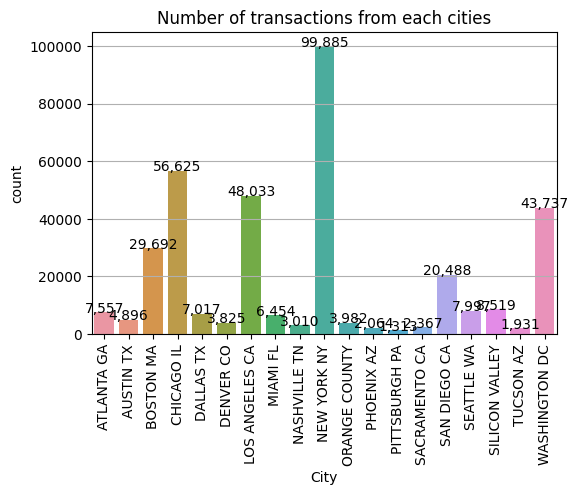

In [12]:
plt.figure(dpi=100)
ax = sns.countplot(x=cab.City)
show_values_on_bars(ax)
plt.grid(which="both", axis="y")
plt.title("Number of transactions from each cities")
_ = plt.xticks(rotation=90)

Most data comes from a few cities, namely BOSTON MA, CHICAGO IL, LOS ANGELES CA, NEW YORK NY, SAN DIEGO CA, and WASHINGTON DC being significant from the graph. This means that most income comes from these few cities. However, be careful that this doesn't mean they're the most popular source of transportation in the city. We will see later when we compare the number of users with population when looking at `City.csv`. 

Next, let's check on `KM travelled`. 

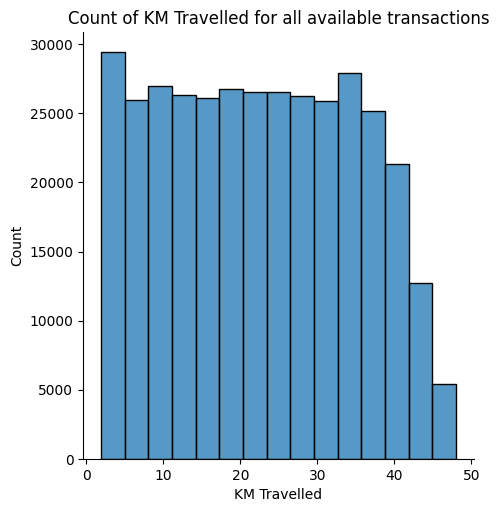

In [13]:
sns.displot(cab["KM Travelled"], bins=15)
_ = plt.title("Count of KM Travelled for all available transactions")

It is noted that there are *various distance travelled* before 40KM (meaning that they're all popular, not just short distance travels are popular nor long distance as it doesn't form a gaussian), and those after 40KM significantly reduce the number of transactions, so ultra long distance wasn't very popular. Is there are relationship between which type of company and their distance travelled? 

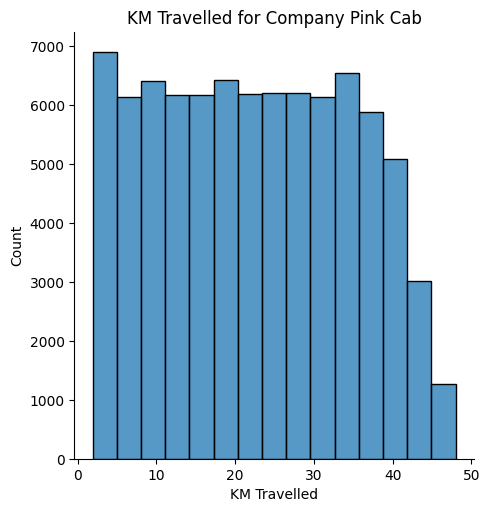

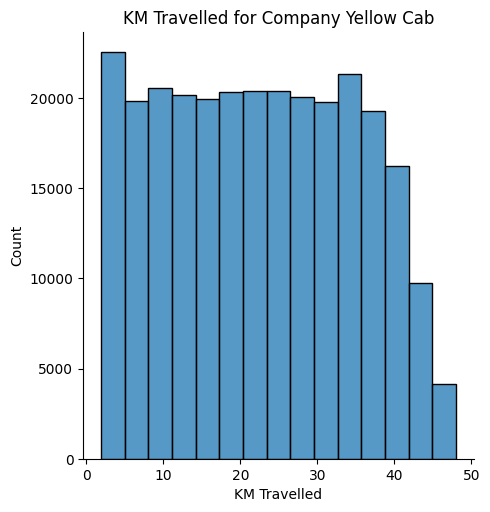

In [14]:
for i in cab.groupby("Company")["KM Travelled"]: 
    sns.displot(i[1], bins=15)
    plt.title(f"KM Travelled for Company {i[0]}")
    plt.show()

Nope, although one have less people use, their KM travelled aren't affected by which company. People uses which company regards on their preference **rather than** one cab is more popular with long distance than short distance, for example. 

How about company and their distributions? What cities do they fetch? 

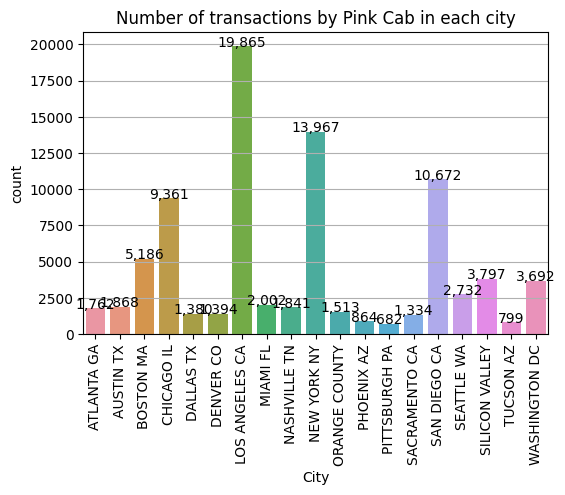

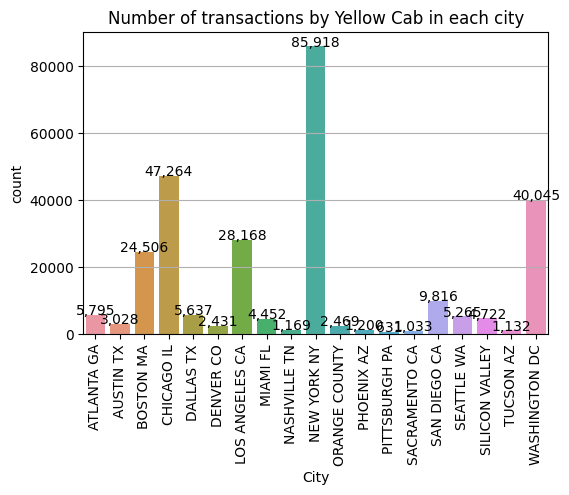

In [15]:
for i in cab.groupby("Company")["City"]: 
    ax = sns.countplot(x=i[1])
    show_values_on_bars(ax, h_v="v", space=0.4)
    plt.grid(which="both", axis="y")
    plt.title(f"Number of transactions by {i[0]} in each city")
    plt.xticks(rotation=90)
    plt.show()

Overall, those cities with most cab transactions still significant. However, there are some where demographics are different. This is especially true for the ratio. For example, there is a higher ratio of people choosing Yellow Cab over Pink Cab in NEW YORK NY (about 6:1), while in LOS ANGELES CA, it has a smaller ratio difference of about 3:2 for Yellow Cab to Pink Cab respectively. Other cities may have different distributions as well, and sometimes more or less 1:1 distribution. 

What we know is, even if one company falls, another can replace it as long as there're enough cab available. Of course, this is true for most cities that have roughly equal ratio, while others like WASHINGTON DC, etc are not true. If Pink Cab is the one that's down, things still goes fine. **However if Yellow Cab is down, things goes awry**. It is therefore recommended **not to give up Yellow Cab** (better for investment). 

Next, looking at price charged and their distributions. 

In [18]:
cab["Price Charged"].mean()

423.44331125901533

Let's make the bins more or less have width of 100. 

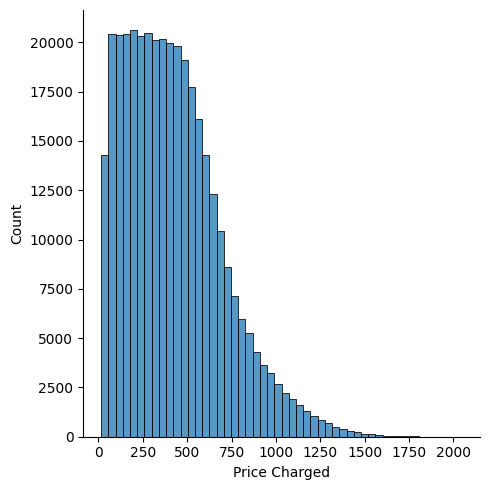

In [20]:
sns.displot(x=cab["Price Charged"], bins=50)

Looks like most pricing charges between 100-600 approximately, after which it decreases logarithmically. This may have (linear) relationship with distance? Let's check by getting their ratio and plot their ratio. 

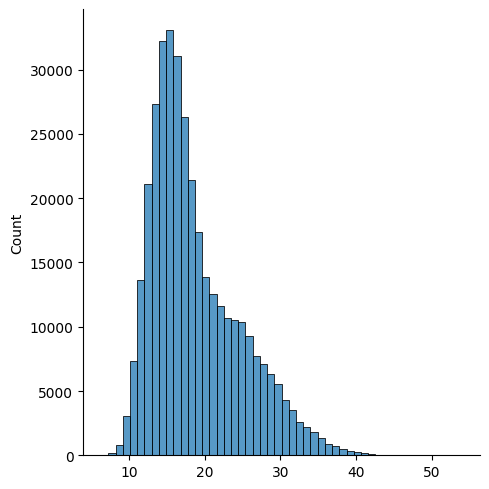

In [19]:
sns.displot(x=cab["Price Charged"] / cab["KM Travelled"], bins=50)

No perfect relationship, we got a Gaussian relationship instead. 

How much does each of the company charges? Does one charge more than the other? 

In [21]:
g = cab.groupby("Company")["Price Charged"]
headers = g.mean().index.tolist()
print("Mean:")
display(HTML(tabulate([g.mean().values], headers=headers, tablefmt="html")))
print("\nMedian:")
display(HTML(tabulate([g.median().values], headers=headers, tablefmt="html")))
print("\nStandard Deviation:")
display(HTML(tabulate([g.std().values], headers=headers, tablefmt="html")))

Mean:


Pink Cab,Yellow Cab
310.801,458.182



Median:


Pink Cab,Yellow Cab
298.06,425.06



Standard Deviation:


Pink Cab,Yellow Cab
181.996,288.386


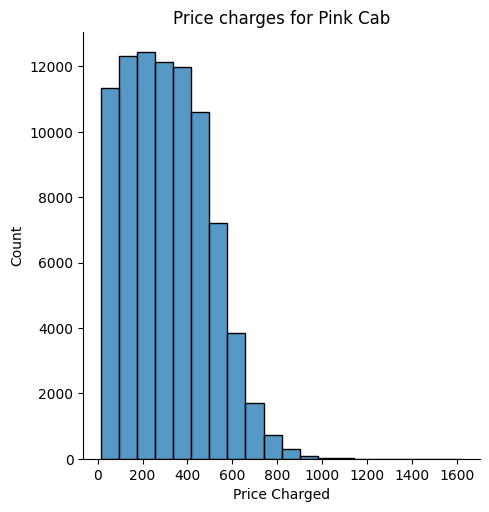

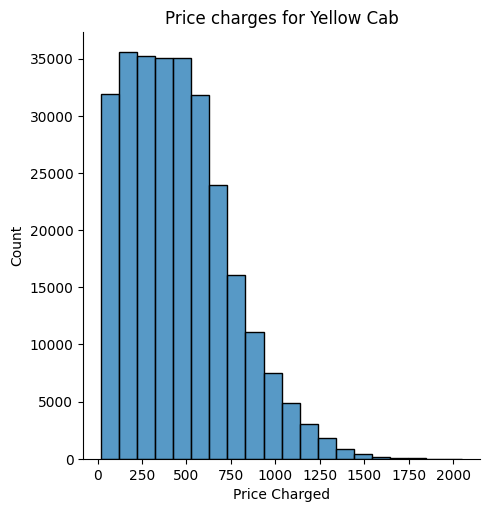

In [22]:
for i in cab.groupby("Company")["Price Charged"]:
    sns.displot(x=i[1], bins=20)
    plt.title(f"Price charges for {i[0]}")

Though more people uses Yellow Cab, it has higher mean and median charges. And despite the higher charges, more people still uses their services. The exact reason is unknown. **Opinionwise (guessing)** would be they could have better services, better facilities (cleaner and newer vehicle for example), and many other reasons. 

Anyway, this reinforce one's point suggesting to **invest in Yellow Cab**. We can see that even pricing more expensive, there are still more users using it. Hence, it is worth for investment. For Pink Cab, it may be (guessed statement) to remain competitive (against Yellow Cab), they decrease their pricing. They're not very worth investment as the ROI isn't as high as Yellow Cab. 

How about price charge dependent on the city? Is it more expensive in a certain city than another? 

Note: This question will be answered later on for easier flow of information. 

Finally, we have `Cost of Trip` to check. From one's understanding, this is how much price to pay for each trip, so `Price Charged` - `Cost of Trip` is the income earned by the company. We will deal with `Cost of Trip` first before dealing with *income*. 

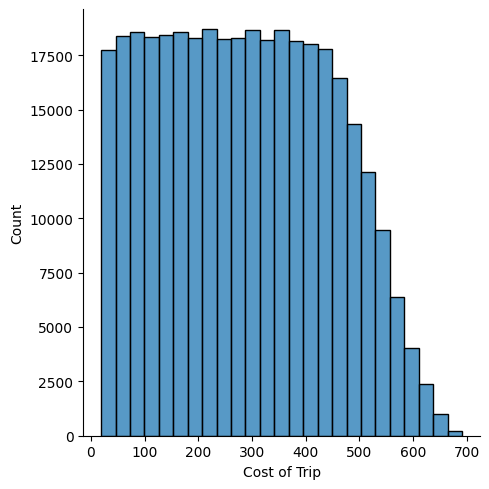

In [23]:
sns.displot(x=cab["Cost of Trip"], bins=25)

In [24]:
cab["Cost of Trip"].max(), cab["Price Charged"].max()

(691.2, 2048.03)

We can see that the maximum `Cost of Trip` and `Price Charged` is a big difference, so they earned different amounts. Let's check their mean, median and standard deviation for `Cost of Trip`, just like how we did for `Price Charged`. 

In [25]:
g = cab.groupby("Company")["Cost of Trip"]
headers = g.mean().index.tolist()
print("Mean:")
display(HTML(tabulate([g.mean().values], headers=headers, tablefmt="html")))
print("\nMedian:")
display(HTML(tabulate([g.median().values], headers=headers, tablefmt="html")))
print("\nStandard Deviation:")
display(HTML(tabulate([g.std().values], headers=headers, tablefmt="html")))

Mean:


Pink Cab,Yellow Cab
248.149,297.922



Median:


Pink Cab,Yellow Cab
246.33,295.596



Standard Deviation:


Pink Cab,Yellow Cab
135.403,162.549


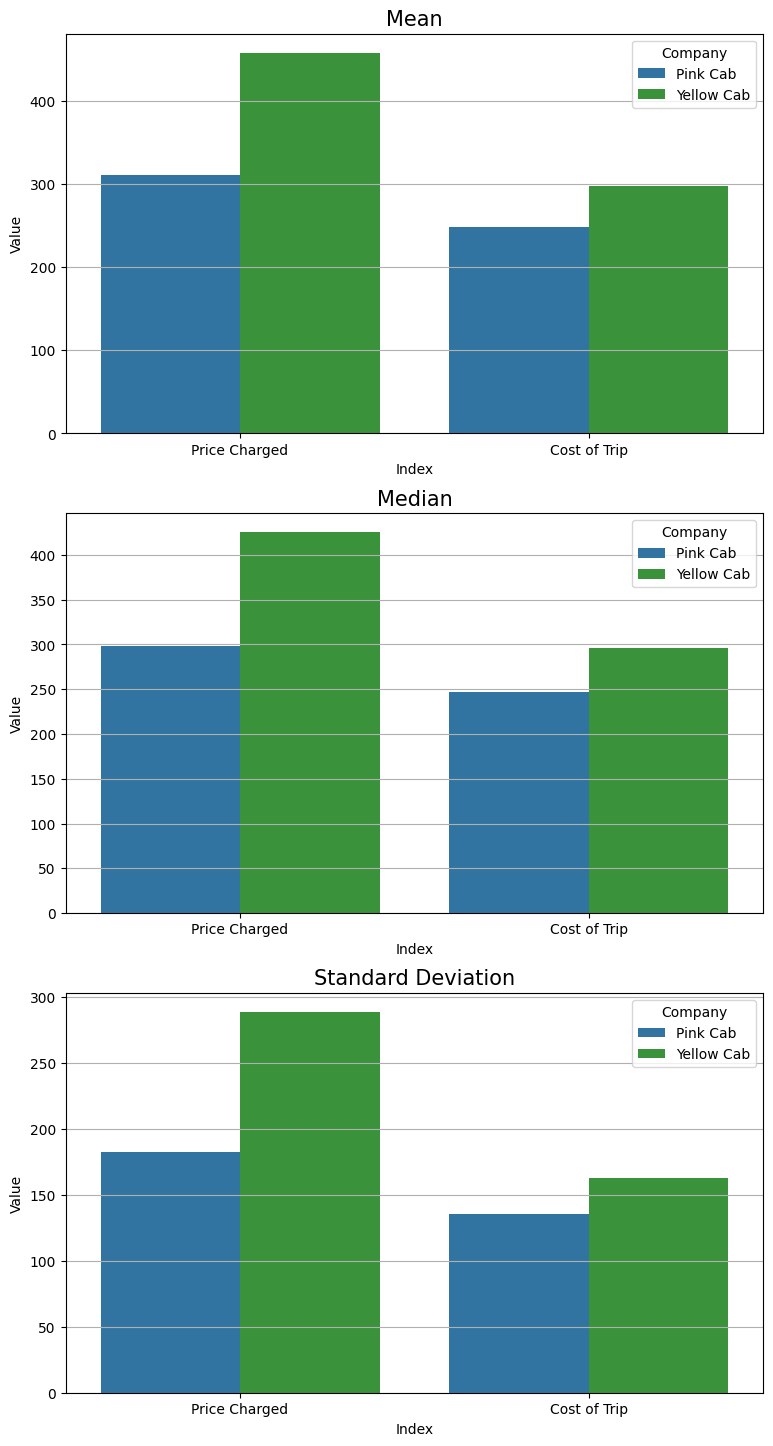

In [26]:
g = cab.groupby("Company")["Price Charged"]
h = cab.groupby("Company")["Cost of Trip"]

mean = pd.DataFrame([g.mean(), h.mean()])
median = pd.DataFrame([g.median(), h.median()])
std = pd.DataFrame([g.std(), h.std()])

fig, axs = plt.subplots(3, 1, figsize=(9, 18))
dfs = [mean, median, std]
titles = ["Mean", "Median", "Standard Deviation"]
my_colors = np.array(plt.get_cmap("tab10").colors)[np.array([0, 2])]

for ax, df_temp, title in zip(axs, dfs, titles):
    df_temp.reset_index(level=0, inplace=True)
    df_temp = df_temp.melt(id_vars="index").rename(columns=str.title)
    sns.barplot(x="Index", y="Value", hue="Company", 
                data=df_temp, ax=ax, ci=None,
                palette=my_colors)
    ax.set_title(title, fontsize=15)
    ax.grid(axis="y")

This is reinforcing our point. We see that the `Cost of Trip` is higher for `Yellow Cab`, resulting in them charging higher numbers. However, they also have significantly more earnings because the ratio of `Price Charged` between `Yellow Cab` and `Pink Cab` is higher than the ratio of `Cost of Trip`. We can see this by the height of the bars by eye. 

Let's see how much they earned, on average (their mean, median, and std).

In [27]:
cab["income"] = cab["Price Charged"] - cab["Cost of Trip"]

In [28]:
g = cab.groupby("Company")["income"]
g = pd.DataFrame([g.mean(), g.median(), g.std()])
g.index = ["mean", "median", "std"]
g

Company,Pink Cab,Yellow Cab
mean,62.652174,160.259986
median,41.500000,102.000000
std,77.590378,171.823833


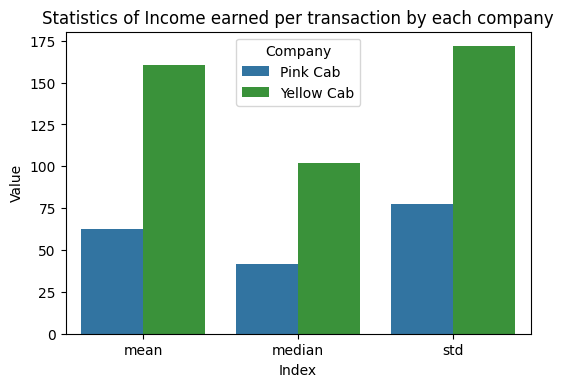

In [29]:
g.reset_index(level=0, inplace=True)
g = g.melt(id_vars="index").rename(columns=str.title)
sns.barplot(x="Index", y="Value", hue="Company", 
                data=g, ci=None, palette=my_colors)
_ = plt.title("Statistics of Income earned per transaction by each company")

Clearly reinforcing our point. Yellow Cab earnings is about 2x-3x of Pink Cab. Choose them. 

# City

In [30]:
city = pd.read_csv("City.csv")
city.head()

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [31]:
len(city), len(cab.City.unique())

(20, 19)

Which city is missing from the `Cab_Data.csv`? 

In [32]:
missing_col = set(city.City.tolist()).difference(set(cab.City.unique()))
missing_col

{'SAN FRANCISCO CA'}

Let's explore a bit on the demographics. 

In [33]:
def replace_commas(x): return x.replace(",", "")

In [34]:
city.Population = city.Population.map(replace_commas)
city.Users = city.Users.map(replace_commas)
city = city.astype({"Population": np.int32, "Users": np.int32})

# We want easier comparison with Cab_Data so we rearrange
# by city than originally by population. 
city = city.sort_values("City")

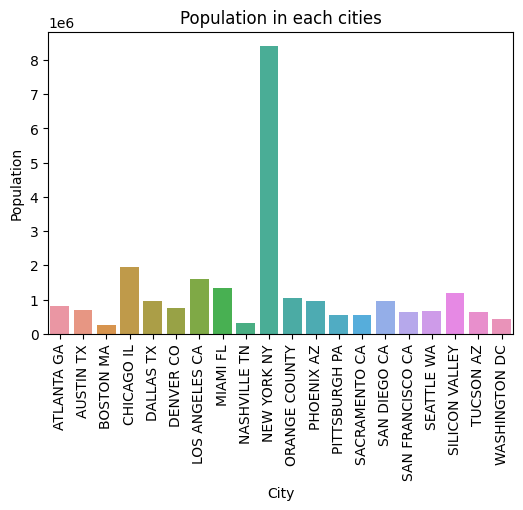

In [35]:
sns.barplot(x="City", y="Population", data=city)
plt.title("Population in each cities")
_ = plt.xticks(rotation=90)

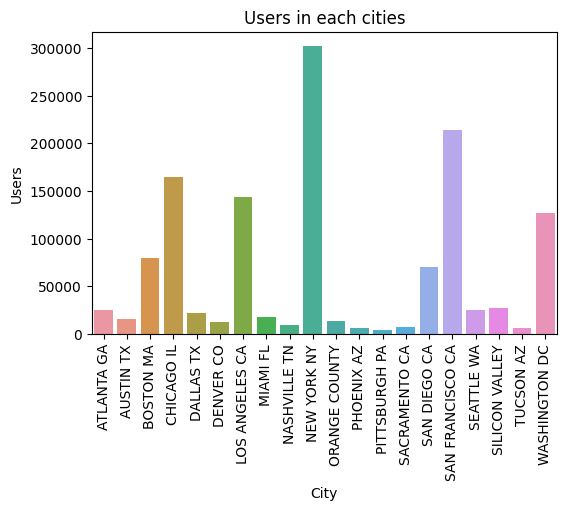

In [36]:
sns.barplot(x="City", y="Users", data=city)
plt.title("Users in each cities")
_ = plt.xticks(rotation=90)

Ratio of population to number of users as percentage. 

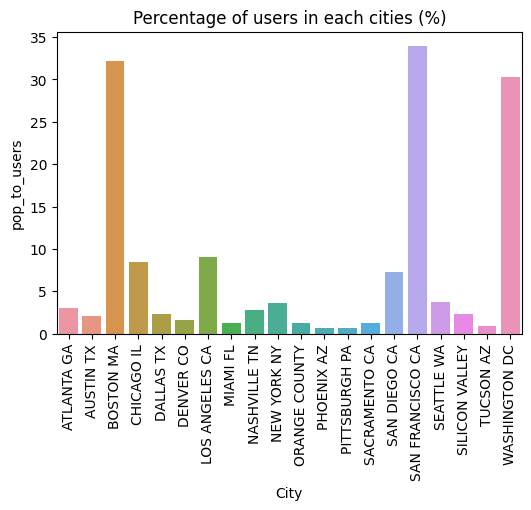

In [37]:
city["pop_to_users"] = city.Users / city.Population * 100
sns.barplot(x="City", y="pop_to_users", data=city)
plt.title("Percentage of users in each cities (%)")
_ = plt.xticks(rotation=90)

It seems like some cities are more popular with cab usage than others. In particular, SAN FRANCISCO CA, WASHINGTON DC, and BOSTON MA have high users to population ratio (lots of people uses Cabs) than other countries. Although NEW YORK NY have the most users, that's because they have an extremely large population compared to other cities rather than it's mostly used by people in the city. 

There's also one important thing to note. **In Cab_Data.csv, there's missing data on SAN FRANCISCO CA**. We note that the number of users (and the percentage of users per city (`pop_to_users`)) is very high for this city. This is **data loss**. 

Before, we skip a question to answer on `Price Charged` against `City`. Now we want to know this information. (We may also do it for `Cost of Trip`). Does having more percentage of users per city makes Cab cheaper/more expensive in the city? We shall deal with mean and median here. 

**Note:** There are other questions like `KM Travelled` against `City` to see how large is their city, which might be related to the `Cost of Trip` and `Price Charged` but it's not important for investment, since we're investing in a certain company, not "per city" basis. 

In [38]:
cab.columns

Index(['Transaction ID', 'Date of Travel', 'Company', 'City', 'KM Travelled',
       'Price Charged', 'Cost of Trip', 'income'],
      dtype='object')

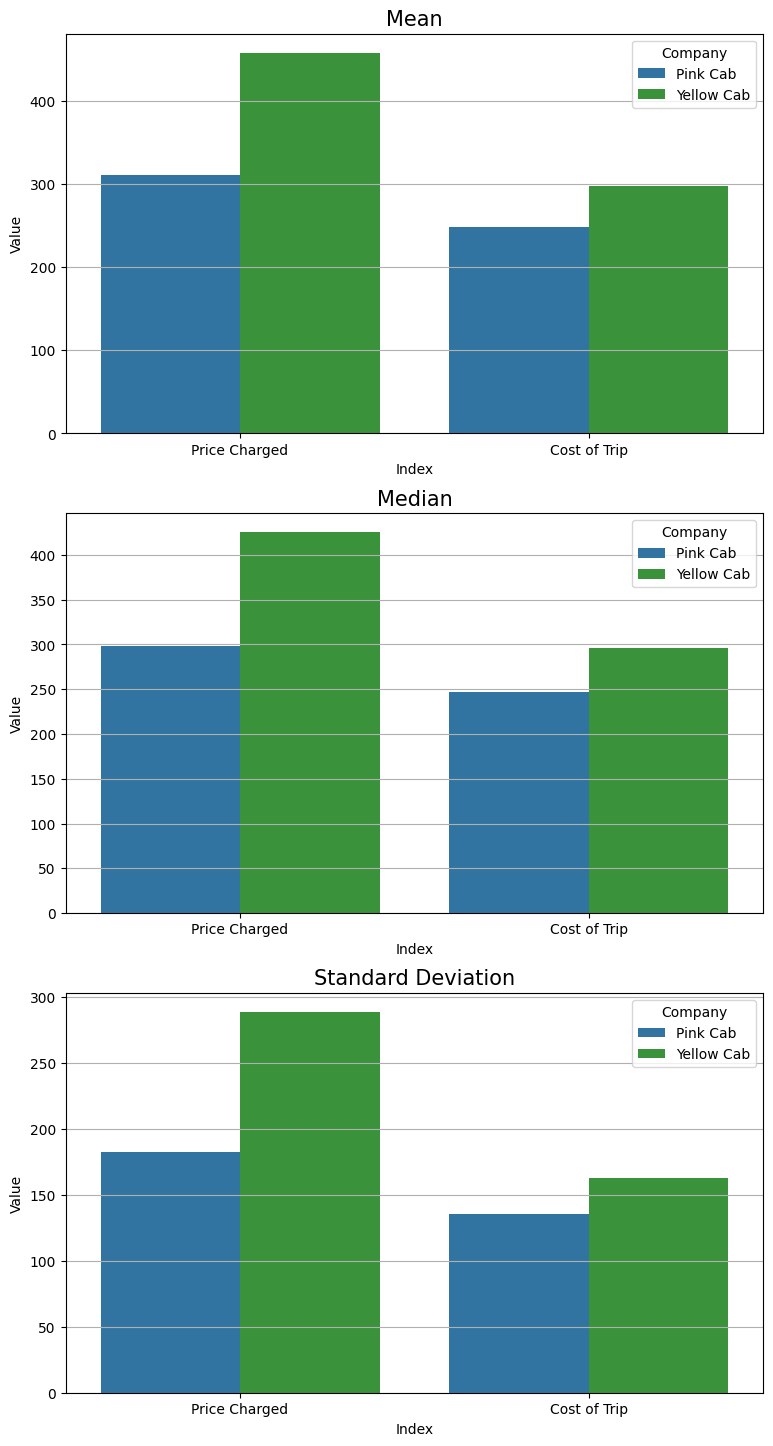

In [39]:
g = cab.groupby("Company")["Price Charged"]
h = cab.groupby("Company")["Cost of Trip"]

mean = pd.DataFrame([g.mean(), h.mean()])
median = pd.DataFrame([g.median(), h.median()])
std = pd.DataFrame([g.std(), h.std()])

fig, axs = plt.subplots(3, 1, figsize=(9, 18))
dfs = [mean, median, std]
titles = ["Mean", "Median", "Standard Deviation"]
my_colors = np.array(plt.get_cmap("tab10").colors)[np.array([0, 2])]

for ax, df_temp, title in zip(axs, dfs, titles):
    df_temp.reset_index(level=0, inplace=True)
    df_temp = df_temp.melt(id_vars="index").rename(columns=str.title)
    sns.barplot(x="Index", y="Value", hue="Company", 
                data=df_temp, ax=ax, ci=None,
                palette=my_colors)
    ax.set_title(title, fontsize=15)
    ax.grid(axis="y")

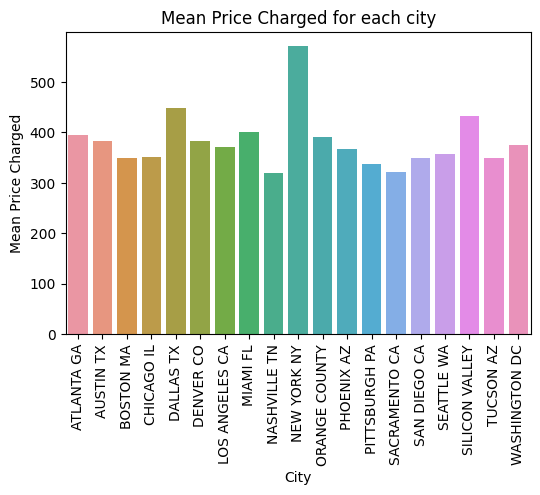

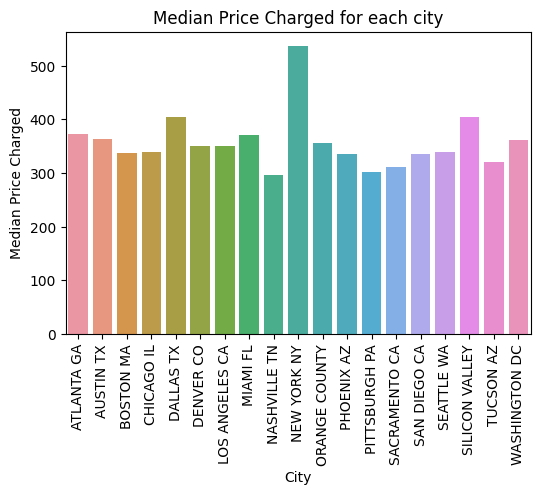

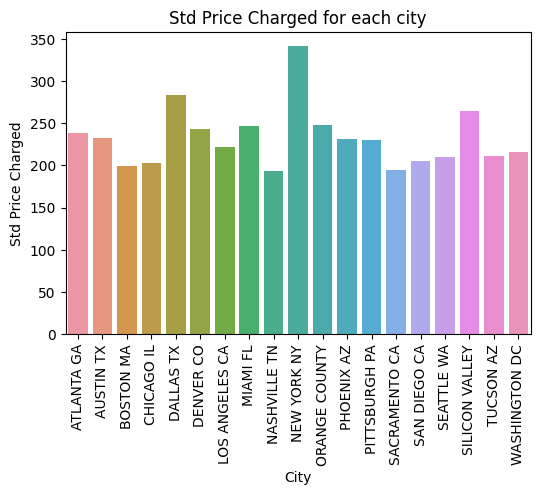

In [40]:
g = cab.groupby("City")["Price Charged"]

g = pd.DataFrame([g.mean(), g.median(), g.std()], index=["Mean", "Median", "Std"]).T 
cols = g.columns
g.reset_index(level=0, inplace=True)

for col in cols:
    ax = sns.barplot(x="City", y=col, data=g)
    ax.set_ylabel(f"{col} Price Charged")
    plt.title(f"{col} Price Charged for each city")
    plt.xticks(rotation=90)
    plt.show()

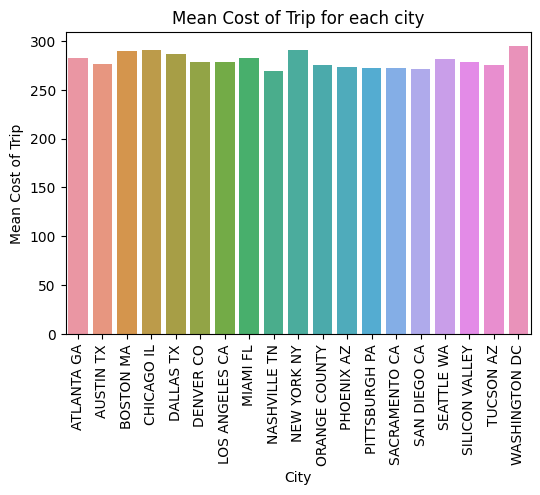

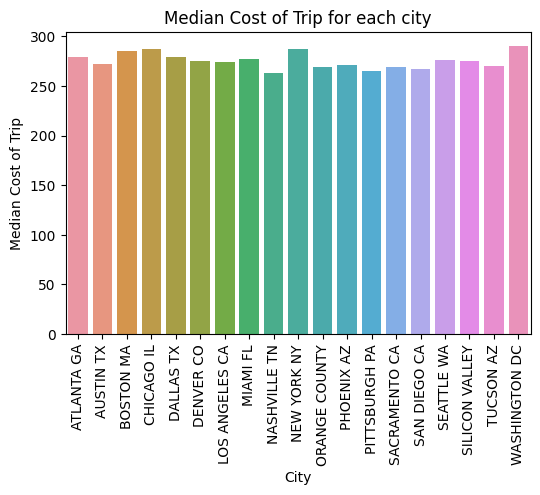

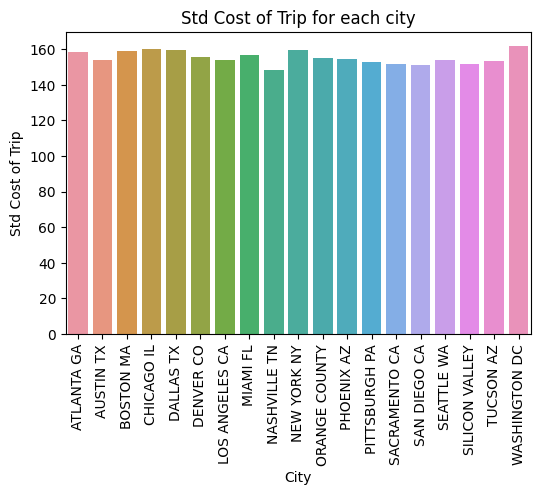

In [41]:
g = cab.groupby("City")["Cost of Trip"]

g = pd.DataFrame([g.mean(), g.median(), g.std()], index=["Mean", "Median", "Std"]).T 
cols = g.columns
g.reset_index(level=0, inplace=True)

for col in cols:
    ax = sns.barplot(x="City", y=col, data=g)
    ax.set_ylabel(f"{col} Cost of Trip")
    plt.title(f"{col} Cost of Trip for each city")
    plt.xticks(rotation=90)
    plt.show()

Looks like there's not much dependency (a.k.a. at least one sees none by eye, we could find correlation using `pd.corr`). Let's do that. We would deal with mean here. We can also deal with median. 

In [42]:
g = cab.groupby("City")["Price Charged"]
h = cab.groupby("City")["Cost of Trip"]
df_temp = pd.DataFrame([g.mean(), h.mean(), 
            city[["City", "pop_to_users"]].set_index("City")["pop_to_users"]
]).drop(columns=list(missing_col)).T
df_temp.corr()

,Price Charged,Cost of Trip,pop_to_users
Price Charged,1.000000,0.473135,-0.129539
Cost of Trip,0.473135,1.000000,0.605442
pop_to_users,-0.129539,0.605442,1.000000


<AxesSubplot:>

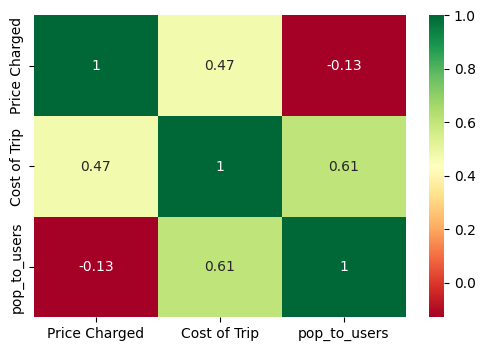

In [44]:
sns.heatmap(df_temp.corr(), xticklabels=df_temp.corr().columns,
            yticklabels=df_temp.corr().index, annot=True, cmap="RdYlGn")

There are some correlations on `Cost of Trip` with `pop_to_users` but generally that isn't very clear because when we see the graph of `Cost of Trip` against `City` they're actually quite flat, so the correlations mostly comes from averaging, and those that does not meet the averaging doesn't correlate. 

Let's try Pearson Correlation: 

In [45]:
corr_cot_ptu, _ = pearsonr(df_temp["Cost of Trip"], df_temp["pop_to_users"])
corr_pc_ptu, _ = pearsonr(df_temp["Price Charged"], df_temp["pop_to_users"])
print(f"Pearson Correlation Cost of Trip X pop_to_users: {corr_cot_ptu}")
print(f"Pearson Correlation Price Charged X pop_to_users {corr_pc_ptu}")

Pearson Correlation Cost of Trip X pop_to_users: 0.605441558917925
Pearson Correlation Price Charged X pop_to_users -0.1295392629962321


They result in the same correlation value. Let's do some scatterplot. 

Text(0.5, 1.0, 'Correlation between Price Charge and pop_to_users')

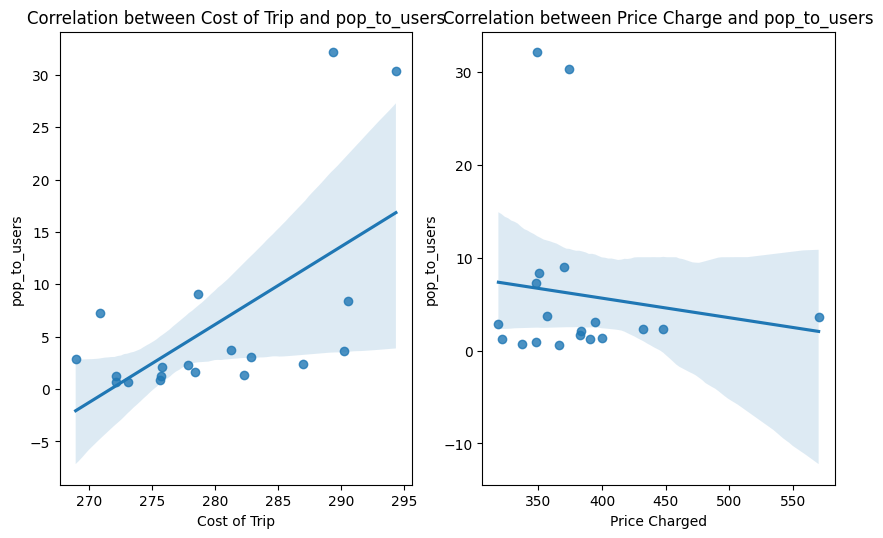

In [46]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
my_colors = np.array(plt.get_cmap("Set1").colors)[np.array([0, 2])]

a = sns.regplot(x=df_temp["Cost of Trip"], y=df_temp["pop_to_users"], 
                    ax=ax1)
b = sns.regplot(x=df_temp["Price Charged"], y=df_temp["pop_to_users"],
                    ax=ax2)

a.set_title("Correlation between Cost of Trip and pop_to_users")
b.set_title("Correlation between Price Charge and pop_to_users")

We shall continue EDA in another notebook because this notebook is too long. 